In [1]:
import requests
import pandas as pd
from pandas import IndexSlice as ix
import textwrap
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from urllib.parse import urlencode, urlparse, unquote

In [3]:
url = 'https://services7.arcgis.com/IyvyFk20mB7Wpc95/arcgis/rest/services/'
query = '/FeatureServer/0/query'
params = dict(where='1=1',
                        outFields='*',
                        outSR='4326',
                        f='geojson')

In [4]:
document = 'Sustainable_Development_Report_2024_(GOAL_DATA_ONLY)'
response = requests.get(url+document+query,params=params)
print(response.status_code)
if response.ok:
    j = response.json()
    goal_data = gpd.GeoDataFrame.from_features(j)

200


In [5]:
document = 'Sustainable_Development_Report_2024_(OVERALL_DATA_ONLY)'
response = requests.get(url+document+query,params=params)
print(response.status_code)
if response.ok:
    j = response.json()
    country_data = gpd.GeoDataFrame.from_features(j)

200


In [6]:
document = 'SDR_2024_Codebook'
response = requests.get(url+document+query,params=params)
print(response.status_code)
if response.ok:
    j = response.json()
    code_data = gpd.GeoDataFrame.from_features(j)

200


In [7]:
from itertools import chain, pairwise


In [8]:
document = 'SDR_2024_TIMESERIES_(Backdated_SDG_Index_Scores)'

hist_data = []
for start, end in pairwise(chain(range(1999,2024,7),[2024])):
    params = dict(where=f'(Year>={start}) AND (Year<={end})',
                  outFields='*',
                  outSR='4326',
                  f='geojson')

    response = requests.get(url+document+query,params=params)
    print(response.status_code)
    if response.ok:
        j = response.json()
        if 'error' in j:
            print(j['error'])
            break
        if 'properties' in j:
            print(j['properties'])
        hist_data.append(gpd.GeoDataFrame.from_features(j))

hist_data = pd.concat(hist_data)

200
200
200
200


In [9]:
hist_data = hist_data.astype({k:float for k,v in hist_data.dtypes.items() if v is np.dtype('O') and k not in (['ID','Country'])})

In [10]:
document = "Sustainable_Development_Report_2024_(INDICATOR_DATA_ONLY)"
params = dict(where='1=1',
                        outFields='*',
                        outSR='4326',
                        f='geojson')
response = requests.get(url+document+query,params=params)
print(response.status_code)
if response.ok:
    j = response.json()
    ind_data = gpd.GeoDataFrame.from_features(j)

200


In [11]:
impute_columns = ind_data.columns[ind_data.columns.str.startswith('impute')]
ind_data[impute_columns] = ind_data[impute_columns].astype('float').fillna(0)>0.5

In [12]:
score_columns = ind_data.columns[ind_data.columns.str.startswith('Score')]
ind_data[score_columns]=ind_data[score_columns].astype('float')

In [13]:
value_columns = ind_data.columns[ind_data.columns.str.startswith('Value')]
ind_data[value_columns]=ind_data[value_columns].astype(float)


In [14]:
year_columns = ind_data.columns[ind_data.columns.str.startswith('Year')]
ind_data[year_columns]=ind_data[year_columns].astype(pd.Int64Dtype())

In [15]:
x = ind_data.columns
x = x[x.str.contains('_')].to_frame(name='name')
x = x['name'].str.split('_',n=1,expand=True)
x = x.reset_index().set_index([1,0])
y = ind_data.columns[ind_data.columns.str.startswith('Value_')].str[6:]
x = x.reindex(pd.MultiIndex.from_product([y,x.index.levels[1]])).unstack(sort=False)['index']
x['goal']=x.index.to_series().str.extract(r'sdg(\d+)_\w+')[0].astype(int)
x.index.name = 'indicator'
x = x.set_index('goal',append=True).swaplevel(0,1)

x


0                                   Rating                 Score  \
goal indicator                                                     
1    sdg1_wpc              Rating_sdg1_wpc        Score_sdg1_wpc   
     sdg1_lmicpov      Rating_sdg1_lmicpov    Score_sdg1_lmicpov   
     sdg1_oecdpov      Rating_sdg1_oecdpov                   NaN   
2    sdg2_undernsh    Rating_sdg2_undernsh   Score_sdg2_undernsh   
     sdg2_stunting    Rating_sdg2_stunting   Score_sdg2_stunting   
...                                    ...                   ...   
17   sdg17_cohaven    Rating_sdg17_cohaven   Score_sdg17_cohaven   
     sdg17_secrecy    Rating_sdg17_secrecy                   NaN   
     sdg17_sprofits  Rating_sdg17_sprofits                   NaN   
     sdg17_statperf  Rating_sdg17_statperf  Score_sdg17_statperf   
     sdg17_multilat  Rating_sdg17_multilat  Score_sdg17_multilat   

0                                   Trend                 Value  \
goal indicator                                                    
1    sdg1_wpc              Trend_sdg1_wpc        Value_sdg1_wpc   
     sdg1_lmicpov      Trend_sdg1_lmicpov    Value_sdg1_lmicpov   
     sdg1_oecdpov      Trend_sdg1_oecdpov    Value_sdg1_oecdpov   
2    sdg2_undernsh    Trend_sdg2_undernsh   Value_sdg2_undernsh   
     sdg2_stunting    Trend_sdg2_stunting   Value_sdg2_stunting   
...                                   ...                   ...   
17   sdg17_cohaven                    NaN   Value_sdg17_cohaven   
     sdg17_secrecy    Trend_sdg17_secrecy   Value_sdg17_secrecy   
     sdg17_sprofits  Trend_sdg17_sprofits  Value_sdg17_sprofits   
     sdg17_statperf  Trend_sdg17_statperf  Value_sdg17_statperf   
     sdg17_multilat                   NaN  Value_sdg17_multilat   

0                                   Year                impute  
goal indicator                                                  
1    sdg1_wpc              Year_sdg1_wpc       impute_sdg1_wpc  
     sdg1_lmicpov      Year_sdg1_lmicpov   impute_sdg1_lmicpov  
     sdg1_oecdpov      Year_sdg1_oecdpov                   NaN  
2    sdg2_undernsh    Year_sdg2_undernsh  impute_sdg2_undernsh  
     sdg2_stunting    Year_sdg2_stunting  impute_sdg2_stunting  
...                                  ...                   ...  
17   sdg17_cohaven    Year_sdg17_cohaven  impute_sdg17_cohaven  
     sdg17_secrecy    Year_sdg17_secrecy                   NaN  
     sdg17_sprofits  Year_sdg17_sprofits                   NaN  
     sdg17_statperf  Year_sdg17_statperf                   NaN  
     sdg17_multilat  Year_sdg17_multilat                   NaN  

[125 rows x 6 columns]

In [16]:
#folder = Path('/home/mirko/Downloads/')
#filename=folder/'Sustainable_Development_Report_2024_(with_indicators).csv'
#data = pd.read_csv(filename)
#filename=folder/'SDR_2024_Codebook.xlsx'
#code_data = pd.read_excel(filename,index_col=0)
#filename=folder/'SDR_2024_TIMESERIES_(Backdated_SDG_Index_Scores).csv'
#data_hist=pd.read_csv(filename)

In [17]:
country_info = country_data.set_index('ID')
goal_score = goal_data[goal_data.columns[goal_data.columns.str.match(r'Goal_\d+_Score')|goal_data.columns.isin(['ID'])]].set_index('ID')
goal_rating = goal_data[goal_data.columns[goal_data.columns.str.match(r'Goal_\d+_Rating')|goal_data.columns.isin(['ID'])]].set_index('ID')
goal_trend = goal_data[goal_data.columns[goal_data.columns.str.match(r'Goal_\d+_Trend')|goal_data.columns.isin(['ID'])]].set_index('ID')

for t in [goal_score, goal_rating, goal_trend]:
    t.rename(columns=lambda x:x.rsplit('_',1)[0].lower().translate({ord('_'):None}),inplace=True)


goal_score_mean = goal_score.agg(['min','median','max'])


In [18]:
goal_hist = hist_data.set_index(['ID','Year'])[goal_score.columns]

In [19]:
goal_titles = {
    "goal1": "No Poverty",
    "goal2": "Zero Hunger",
    "goal3": "Good Health and Well-being",
    "goal4": "Quality Education",
    "goal5": "Gender Equality",
    "goal6": "Clean Water and Sanitation",
    "goal7": "Affordable and Clean Energy",
    "goal8": "Decent Work and Economic Growth",
    "goal9": "Industry, Innovation, and Infrastructure",
    "goal10": "Reduced Inequality",
    "goal11": "Sustainable Cities and Communities",
    "goal12": "Responsible Consumption and Production",
    "goal13": "Climate Action",
    "goal14": "Life Below Water",
    "goal15": "Life on Land",
    "goal16": "Peace, Justice, and Strong Institutions",
    "goal17": "Partnerships for the Goals"
}


In [178]:
ind_data[ind_data['Name'].str.contains('Nig')]

,geometry,ID,Name,Region,Value_sdg1_wpc,Year_sdg1_wpc,impute_sdg1_wpc,Score_sdg1_wpc,Rating_sdg1_wpc,Trend_sdg1_wpc,...,Value_sdg17_statperf,Year_sdg17_statperf,Score_sdg17_statperf,Rating_sdg17_statperf,Trend_sdg17_statperf,Value_sdg17_multilat,Year_sdg17_multilat,Score_sdg17_multilat,Rating_sdg17_multilat,FID
82,POINT (96.80537 61.98953),NGA,Nigeria,Sub-Saharan Africa,31.447,2024,False,56.685,red,↓,...,58.61,2022,44.813,orange,➚,73.154,2023,71.923,yellow,83
96,POINT (9.40167 17.42088),NER,Niger,Sub-Saharan Africa,48.407,2024,False,33.324,red,→,...,65.94,2022,54.587,yellow,↑,64.741,2023,57.902,yellow,97


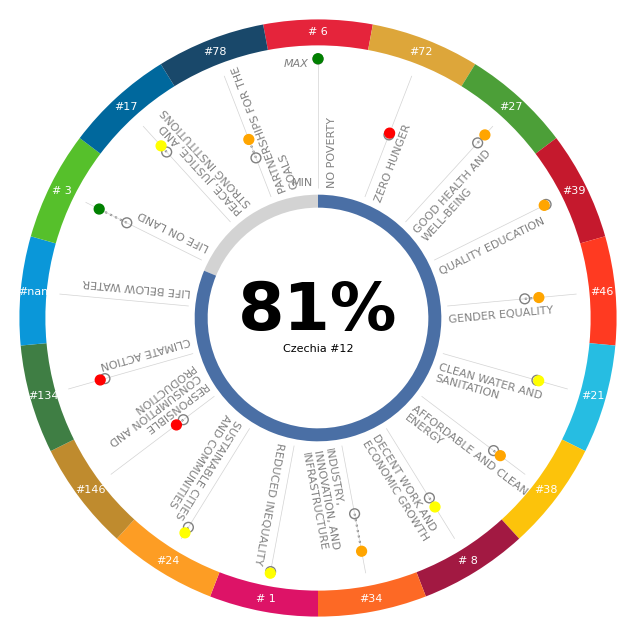

In [181]:
# SDG colors mapping (simplified palette)
sdg_colors = {
    "goal1": "#E5243B", "goal2": "#DDA63A", "goal3": "#4C9F38", "goal4": "#C5192D",
    "goal5": "#FF3A21", "goal6": "#26BDE2", "goal7": "#FCC30B", "goal8": "#A21942",
    "goal9": "#FD6925", "goal10": "#DD1367", "goal11": "#FD9D24", "goal12": "#BF8B2E",
    "goal13": "#3F7E44", "goal14": "#0A97D9", "goal15": "#56C02B", "goal16": "#00689D",
    "goal17": "#19486A"
}

# Polar plot setup
country = 'CZE'
reference_year = 2003

goals = goal_score.columns
num_goals = len(goals)

# Angles for each goal (evenly spaced)
angles = np.linspace(0, 2 * np.pi, num_goals, endpoint=False).tolist()

# Make the plot circular by appending the first angle at the end
angles += angles[:1]

# Set up the figure and polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)  # Rotate the plot so the first goal is at the top
ax.set_theta_direction(-1)  # Make the direction clockwise


# Plot each goal
for i, goal in enumerate(goals):
    # Extract the scores for each year
    #scores = hist_data.loc[goal].values
    #scores = np.array([goal_score_mean.loc['median',goal], goal_score.loc[country,goal]])
    
    scores = goal_hist.loc[ix[country,[reference_year,2023]],goal].values
    scores = 50*(scores-goal_score_mean.loc['min',goal])/(100-goal_score_mean.loc['min',goal])+50

    #goal_rank = goal_hist.loc[ix[:,[reference_year,2023]],goal].unstack(level=1).loc[goal_hist.index.levels[0][~goal_hist.index.levels[0].str.startswith('_')]].rank(ascending=False,method='dense')
    #scores = ((goal_rank.max()-goal_rank.loc[country])/(goal_rank.max()-goal_rank.min())).values*50+50
    
    color = goal_rating.loc[country,goal] 
    if color is None:
        color='black'

    # Compute the angles (duplicated to close the circle)
    goal_angle = angles[i]
    
    # Plot the circles for 2003 (light grey), 2013 (grey), and 2023 (green/red depending on improvement)
    if not(np.isnan(scores).all()):
        ax.scatter([goal_angle] * 2, scores, facecolors=['none',color],edgecolors=['grey', color], s=50, zorder=3)
    
    # Plot the connection line between the years (dotted grey line)
    ax.plot([goal_angle] * 2, scores, color='grey', linestyle=':', zorder=2)
    ax.vlines([goal_angle],50,100,color='lightgray', lw=0.5)

# Customize outer labels (goal numbers in SDG colors)
for i, goal in enumerate(goals):
    ax.text(angles[i]+np.deg2rad(4), 50, 
                '\n'.join(textwrap.wrap(goal_titles[goal].upper(),20)),
                rotation_mode='anchor', rotation=90-np.degrees(angles[i]),
                va='top',
                ha='left', 
                color='gray',
                fontsize=8, )

    goal_rank = goal_hist.loc[ix[:,[reference_year,2023]],goal].unstack(level=1).loc[goal_hist.index.levels[0][~goal_hist.index.levels[0].str.startswith('_')]].rank(ascending=False,method='dense')

    ax.text(angles[i], 110, 
                f'#{goal_rank.loc[country,2023]:2.0f}',
                #rotation_mode='anchor', rotation=90-np.degrees(angles[i]),
                va='center',
                ha='center', 
                color='white',
                #color=sdg_colors[goal], 
                fontsize=8)


pct = country_info.loc[country,'Overall_Score']
name = country_info.loc[country,'Name']
rank = country_info.loc[country,'Overall_Rank']

plt.barh(45,(100-pct)/100*2*np.pi,height=5,color='lightgray',left=pct/100*2*np.pi)
plt.barh(45,pct/100*2*np.pi,height=5,color="#4A6FA5")

plt.barh(110,height=10,width=2*np.pi/num_goals,left=np.array(angles[0:-1])-np.pi/num_goals,color=sdg_colors.values())



ax.text(np.pi,10,f'{pct:2.0f}%',va='bottom',ha='center',fontsize=48,fontweight='bold')
ax.text(np.pi,10,f'{name} #{rank:2.0f}',va='top',ha='center',fontsize=8)

ax.text(0-np.deg2rad(2), 50, 
            'MIN',
            rotation_mode='anchor', 
            va='bottom',
            ha='right', 
            color='gray',
            #color=sdg_colors[goal], 
            fontsize=8, )

ax.text(0-np.deg2rad(2), 100, 
            'MAX',
            rotation_mode='anchor',
            va='top',
            ha='right', 
            color='gray',
            #color=sdg_colors[goal], 
            fontsize=8, style='italic' )

# Remove radial labels

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.spines['polar'].set_visible(False)


In [21]:
import seaborn as sns

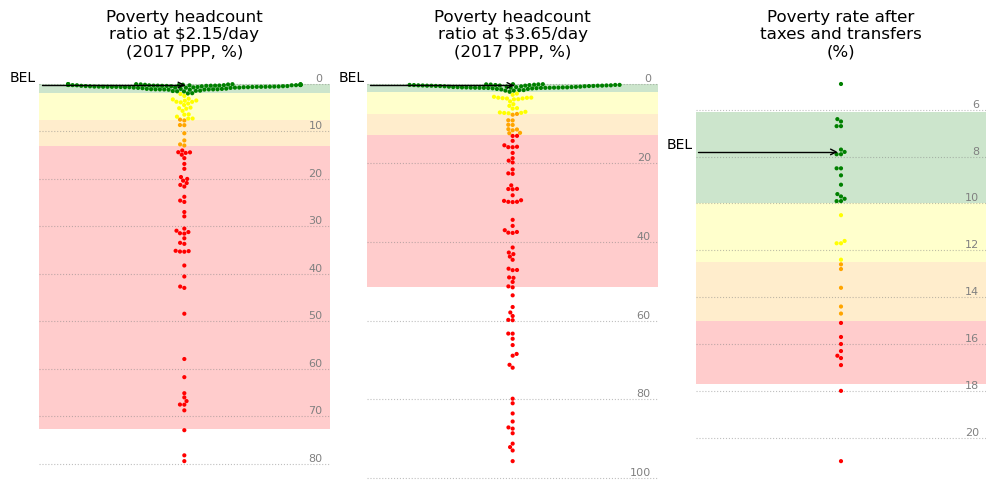

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to map ratings to colors
def rating_to_color(rating):
    color_map = {
        'green': 'green',
        'yellow': 'yellow',
        'orange': 'orange',
        'red': 'red'
    }
    return color_map.get(rating.lower(), 'gray')  # Default to gray if rating is not recognized

# Function to filter indicators for a specific SDG goal
def filter_sdg_indicators(ind_data, sdg_goal):
    sdg_cols = [col for col in ind_data.columns if f'{sdg_goal}_' in col and 'Value' in col]
    return ind_data[['ID']+sdg_cols + [col.replace('Value', 'Rating') for col in sdg_cols]].set_index('ID')

# Function to plot SDG Goal indicators using swarmplot
def plot_sdg_indicators(ind_data, code_data, highlight=None):
    # Find indicator columns (these should already be filtered outside the function)
    sdg_cols = [col for col in ind_data.columns if 'Value' in col]
    n_indicators = len(sdg_cols)
    
    # Set up a grid layout: 3 plots per row
    rows = (n_indicators + 2) // 3  # Number of rows, ceil(n_indicators / 3)
    fig, axes = plt.subplots(rows, 3, figsize=(10, rows * 5), sharey=False)
    
    # Flatten axes for easier iteration (axes could be 2D if multiple rows)
    axes = axes.flatten()

    for i, indicator in enumerate(sdg_cols):
        ax = axes[i]
        
        # Extract corresponding rating column for color mapping
        rating_col = indicator.replace('Value', 'Rating')

        # Filter the data for this indicator
        ind_subset = ind_data[[indicator, rating_col]]
        ind_subset.loc[:,rating_col] = ind_subset[rating_col].fillna('gray')
        ind_subset = ind_subset[[indicator, rating_col]].dropna()

        # Apply jitter only to values that are exactly 0, and move them slightly into the negative range
        #ind_subset[indicator] = np.where(ind_subset[indicator] < 1,
        #                                 np.random.uniform(-1, -0, size=len(ind_subset)),
        #                                 ind_subset[indicator])

        # Explicit color mapping for the rating values
        color_order = ['green', 'yellow', 'orange', 'red']
        sns.swarmplot(
            x=np.zeros(len(ind_subset)),  # Single column for swarmplot (no region needed)
            y=ind_subset[indicator],
            warn_thresh = 1,
            legend=False,
            size=3,
            hue=ind_subset[rating_col],
            palette={rating: rating for rating in color_order},
            ax=ax
        )


        if highlight:
            of = ax.collections[0].get_offsets()
            for ind in highlight:
                if ind in ind_subset.index:
                    ix = ind_subset.index.get_loc(ind)            
                    assert(ind_subset.iloc[ix][indicator]==of[ix][1])
                    ax.annotate(ind,of[ix],(-0.6,of[ix][1]),
                                ha='left', va='bottom',                                  
                                arrowprops = dict(arrowstyle="->",
                                                 connectionstyle='angle,angleA=45, angleB=180,rad=0',

                                                 ))
        
        # Match the full indicator name in code_data (e.g., 'sdg1_wpc', 'sdg1_lmicpov')
        ind_code = indicator.split('Value_')[-1]  # Extract the actual indicator code (e.g., 'sdg1_wpc')
        thresholds = code_data[code_data['IndCode'] == ind_code]

        # Add threshold lines and the goal line (from Optimum in code_data)
        if not thresholds.empty:
            green_thr = thresholds['greenthr'].values[0]
            red_thr = thresholds['redthr'].values[0]
            optimum = thresholds['Optimum'].values[0]  # Use Optimum for the goal line
            orange_thr = (green_thr+red_thr)/2
            lower_bound = thresholds['lower_bound'].values[0]  

        
            ax.axhspan(green_thr, optimum, facecolor='green', alpha=0.2)
            ax.axhspan(orange_thr, green_thr, facecolor='yellow', alpha=0.2)
            ax.axhspan(red_thr, orange_thr, facecolor='orange', alpha=0.2)
            ax.axhspan(lower_bound, red_thr, facecolor='red', alpha=0.2)
              

            if green_thr<red_thr:
                # Reverse the y-axis to have 0 (best) at the top and 100 (worst) at the bottom
                ax.invert_yaxis()
        

        # Remove y-axis label since it's not important
        ax.set_ylabel('')
        ax.set_xticks([])  # Remove x-axis ticks since we're not plotting regions
        #ax.set_axis_off()
        for sp in ax.spines.values():
            sp.set_visible(False)
        #ax.grid(axis='y', linestyle=':', color='lightgray')
        ax.tick_params(
            axis='y',
            colors='gray', 
            length=0, 
            labelsize=8,             
            labelright=True,
            labelleft=False,
            pad=-5,
            direction='in',
            gridOn=True,
            grid_linestyle=':',
            grid_color='gray',
            grid_alpha=0.5) 

        for label in ax.get_yticklabels():
            label.set_horizontalalignment('right')
            label.set_verticalalignment('bottom')
        #    label.set_color('gray')
                
        title = code_data[code_data['IndCode'] == indicator.split('Value_')[-1]]['Label'].values[0]

        ax.set_title('\n'.join(textwrap.wrap(title,20)), fontfamily=['Dejavu sans'], size=12)

        

    # Remove unused subplots if n_indicators < len(axes)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust the layout to make space for vertical titles
    plt.tight_layout()
    plt.show()



sdg1_data = filter_sdg_indicators(ind_data, 'sdg1')
plot_sdg_indicators(sdg1_data, code_data, ['BEL'])


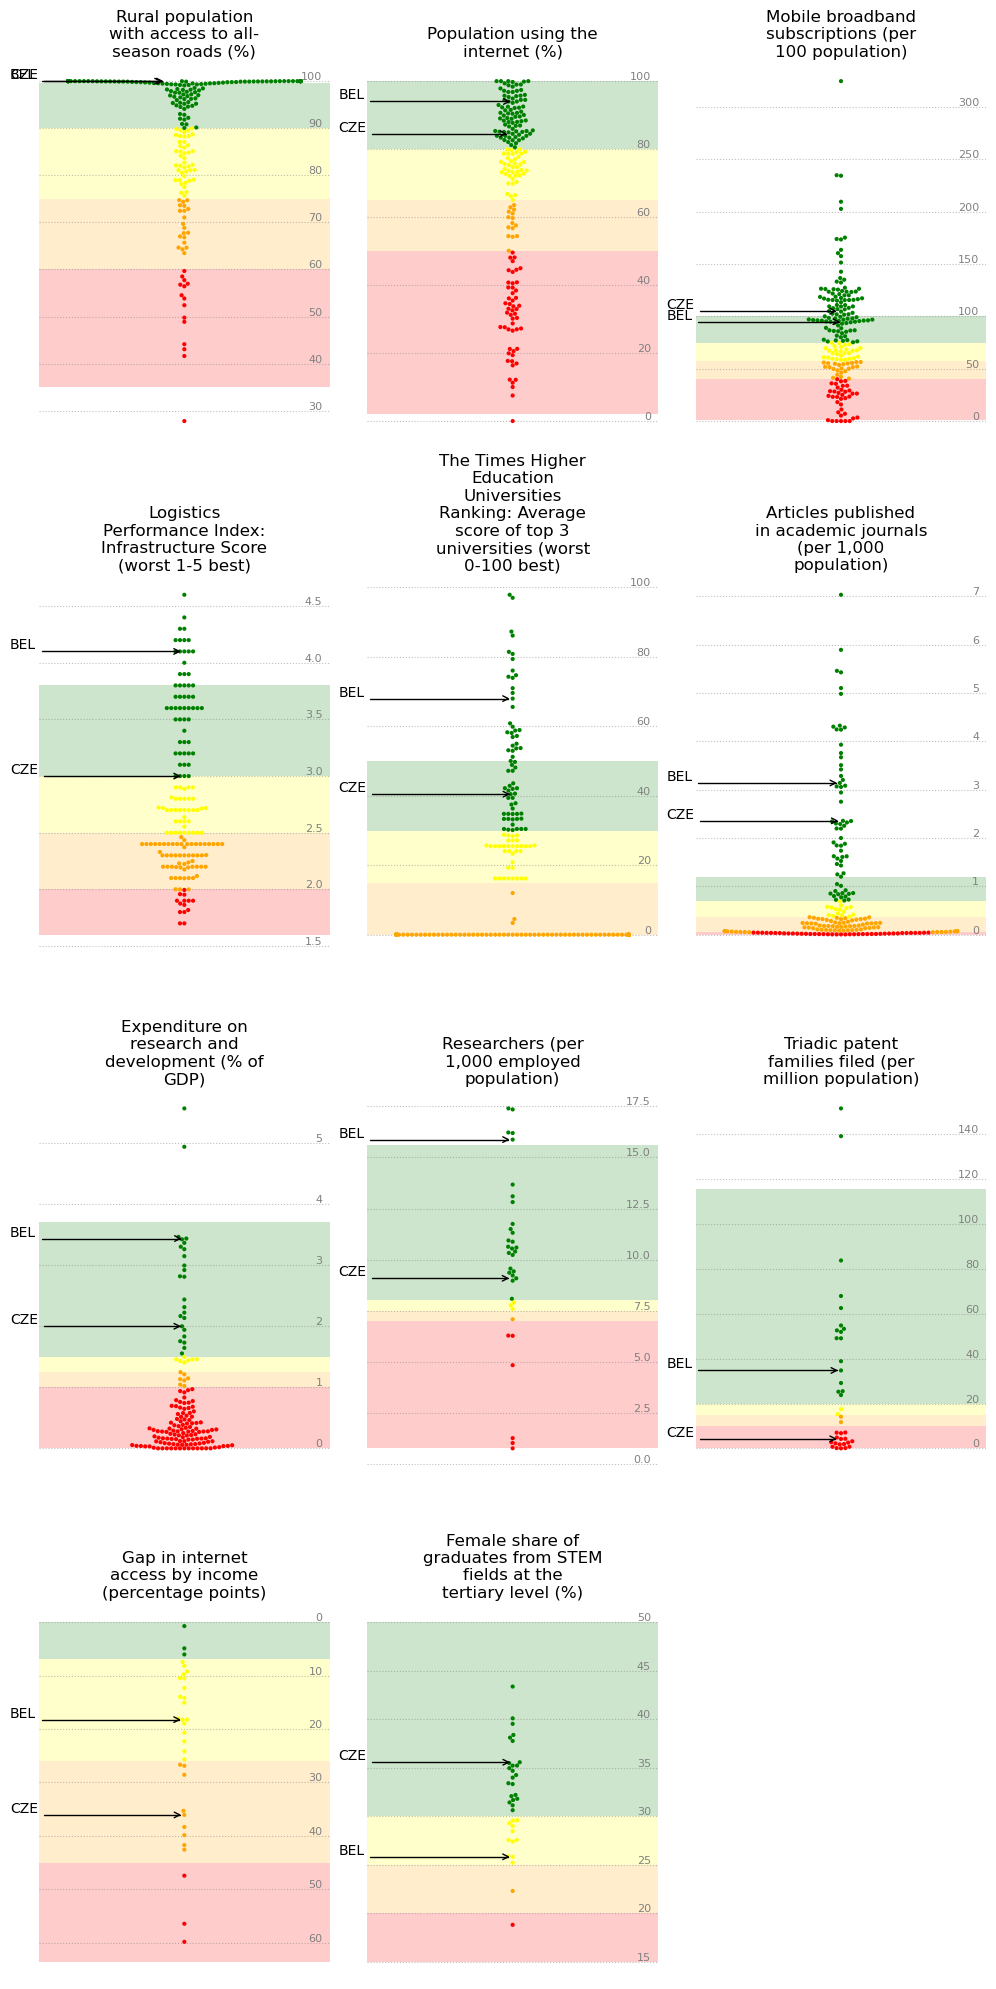

In [183]:
sdg2_data = filter_sdg_indicators(ind_data, 'sdg9')
plot_sdg_indicators(sdg2_data, code_data, highlight=['CZE','BEL'])